# Session 5 - Document classification and prediction

## You have been asked to build a document classifier that helps your communication staff determine the audience for incoming news articles. 

They have provided you with some test data that has the article and their determination of the audience (Executive, Staff, Everyone).  They also included the number of "Likes" the story got because they think that might be helpful in determining who should read things.   

In [17]:
# set up the environment
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
pathname = "C:\\Users\\Paul\\Desktop\\Rockhurst\\BIA 6304-Text Mining\\Week 5" #where to get/put files
pd.set_option('display.max_colwidth', 15000) #important for getting all the text


In [18]:
newsdf = pd.read_csv(pathname + "\\nytnews_tagged.csv", index_col = 0) 

print(newsdf.shape)
print(list(newsdf))

(3848, 7)
['description', 'headline', 'url', 'text', 'cleantext', 'Audience', 'likes']


### Don't hesitate to investigate your data before deciding on what preprocessing needs to be done
### Remember:
* Some processing needs to be done before creating the feature space: custom dictionary replacements, stemming, lemmatization (or definition of stemmer/lemmatizer) for vectorization step
* stopwords and lowercase changes are options *during* vectorization and do not need to be done ahead of time




In [19]:
# quick peak at basic feature space
prelim = CountVectorizer(binary=False, stop_words = 'english') 
prelim_dm = prelim.fit_transform(newsdf['text'])
print(prelim_dm.shape)

names = prelim.get_feature_names()
print(type(names), len(names))

count = np.sum(prelim_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

# storing this for later use
keep_count = count_df.sort_values(['count'], ascending = False)

(3848, 62296)
<class 'list'> 62296
<class 'list'> 62296


In [20]:
# a little preprocessing
import re
news_dict = {'united states':'us','states':'state', 'years':'year',
             'new york': 'ny', 'republicans':'republican', 'schools':'school',
            'companies':'company'}


def multiple_replace(dict, text): 

  """ Replace in 'text' all occurences of any key in the given
  dictionary by its corresponding value.  Returns the new string.""" 
  text = str(text).lower()

  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

newsdf['cleantext'] = newsdf.text.apply(lambda x: multiple_replace(news_dict, x))


In [21]:
# create a custom stopwords list - I choose to start with the nltk list
from nltk.corpus import stopwords

nltk_stopwords = stopwords.words("english")

print(type(nltk_stopwords))
print(len(nltk_stopwords))
my_stopwords = nltk_stopwords + ["mr", "ms", "say","said", "0", '000','10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '21', '22', '23', '24', '25', '27', '30', '300', '35', '40', '45', '50', '500', '60', '70', '80']
print(len(my_stopwords))

<class 'list'>
179
222


In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# instantiate vectorizer(s)
cv1 = CountVectorizer(lowercase=True, 
                     stop_words=my_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2)) 
tfidf1 = TfidfVectorizer(lowercase=True, 
                        stop_words= my_stopwords, 
                        max_df=0.95, 
                        min_df=0.05,
                        ngram_range = (1,2)) 

choice = TfidfVectorizer(lowercase=True,
                         use_idf=True,
                         stop_words=my_stopwords,
                         max_df = 0.95,
                         min_df = 0.05)
#choose your favorite parameter combination

# fit and transform text
cv_dm = cv1.fit_transform(newsdf['cleantext'])
tfidf_dm = tfidf1.fit_transform(newsdf['cleantext'])
choice_dm = choice.fit_transform(newsdf['cleantext'])

# print matrix shape(s)
print(cv_dm.shape)
print(tfidf_dm.shape)
print(choice_dm.shape)
names = cv1.get_feature_names()
print(type(names), len(names))
#save this feature list for later
big_feature_list = cv1.get_feature_names()

(3848, 1236)
(3848, 1236)
(3848, 1207)
<class 'list'> 1236


In [24]:
count = np.sum(cv_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

<class 'list'> 1236


,count
year,10314
one,8680
would,8627
like,6614
people,5547
new,5022
two,4899
time,4757
could,4620
also,4316


In [11]:
# quick peak at the whole list of feature names
#good to investigate at first but PLEASE 
#comment this out before creating the HTML
#print(cv1.get_feature_names()) 

### We want to predict the audience.  What does our target variable look like?

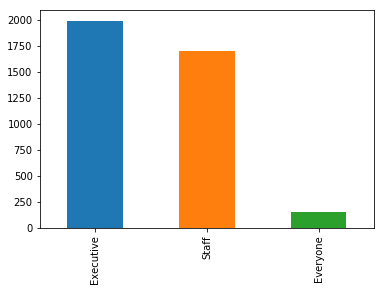

In [26]:
# What does our target variable look like?
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# get a feel for the distribution
newsdf['Audience'].value_counts().plot(kind='bar')

## Now let's try to build a model to predict the classification

### First create the training and test datasets

In [30]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
print(type(X), X[0:10])


y = newsdf['Audience'].values #this is an array of labels
print(type(y), y[0:10])

 

<class 'numpy.ndarray'> [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'> ['Executive' 'Staff' 'Executive' 'Executive' 'Executive' 'Executive'
 'Staff' 'Staff' 'Everyone' 'Executive']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2693, 1236)
(1155, 1236)
(2693,)
(1155,)


## Decision Tree

Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [32]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a Decision Tree model to the data
model = DecisionTreeClassifier(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.5636363636363636
accuracy: 0.5636363636363636
             precision    recall  f1-score   support

   Everyone       0.02      0.02      0.02        58
  Executive       0.60      0.62      0.61       599
      Staff       0.56      0.56      0.56       498

avg / total       0.56      0.56      0.56      1155



### This is a HUGE tree.  In reality we would use some of the settings to prune it down.

## Naive Bayes

http://blog.yhathq.com/posts/naive-bayes-in-python.html

In [33]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.7004329004329004
accuracy: 0.7004329004329004
             precision    recall  f1-score   support

   Everyone       0.09      0.05      0.07        58
  Executive       0.72      0.78      0.75       599
      Staff       0.71      0.68      0.70       498

avg / total       0.69      0.70      0.69      1155



## Logistic Regression

http://blog.yhathq.com/posts/logistic-regression-and-python.html

In [41]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.7506493506493507
accuracy: 0.7506493506493507
             precision    recall  f1-score   support

   Everyone       0.00      0.00      0.00        58
  Executive       0.75      0.83      0.79       599
      Staff       0.75      0.74      0.74       498

avg / total       0.71      0.75      0.73      1155



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Confusion Matrix

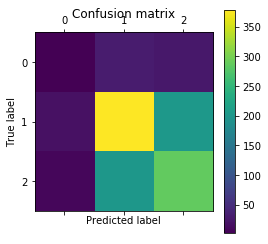

[[  2  30  26]
 [ 19 378 202]
 [  9 201 288]]


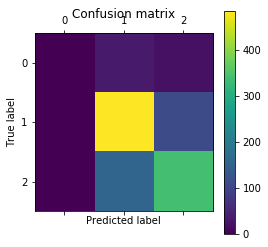

[[  0  36  22]
 [  0 486 113]
 [  0 158 340]]


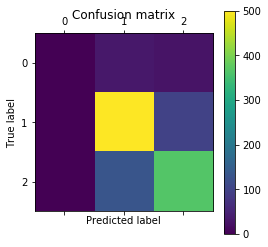

[[  0  32  26]
 [  0 500  99]
 [  0 131 367]]


In [42]:
# display confusion matrix
def create_cm(t1, t2):
    cm = metrics.confusion_matrix(t1, t2)
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(cm)

create_cm(clf1_expected, clf1_predicted)
create_cm(clf2_expected, clf2_predicted)
create_cm(clf3_expected, clf3_predicted)

# Do weights help?

In [44]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = tfidf_dm.toarray()  #remember this is the output from the vectorizer
print(type(X), X[0:10])


y = newsdf['Audience'].values #this is an array of labels
print(type(y), y[0:10])
 

<class 'numpy.ndarray'> [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.04837011 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.04178052 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'> ['Executive' 'Staff' 'Executive' 'Executive' 'Executive' 'Executive'
 'Staff' 'Staff' 'Everyone' 'Executive']


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2693, 1236)
(1155, 1236)
(2693,)
(1155,)


In [46]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a decision tree model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.5783549783549784
accuracy: 0.5783549783549784
             precision    recall  f1-score   support

   Everyone       0.07      0.03      0.05        58
  Executive       0.62      0.63      0.63       599
      Staff       0.56      0.58      0.57       498

avg / total       0.57      0.58      0.57      1155



In [47]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.7151515151515152
accuracy: 0.7151515151515152
             precision    recall  f1-score   support

   Everyone       0.00      0.00      0.00        58
  Executive       0.71      0.81      0.76       599
      Staff       0.72      0.68      0.70       498

avg / total       0.68      0.72      0.70      1155



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.7506493506493507
accuracy: 0.7506493506493507
             precision    recall  f1-score   support

   Everyone       0.00      0.00      0.00        58
  Executive       0.75      0.83      0.79       599
      Staff       0.75      0.74      0.74       498

avg / total       0.71      0.75      0.73      1155



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


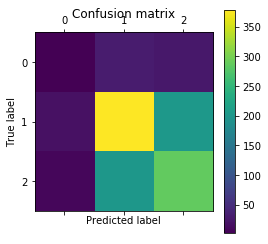

[[  2  30  26]
 [ 19 378 202]
 [  9 201 288]]


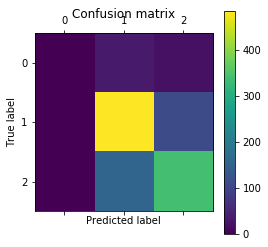

[[  0  36  22]
 [  0 486 113]
 [  0 158 340]]


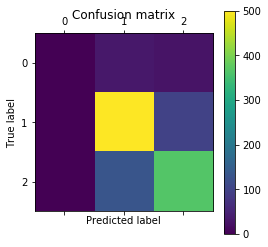

[[  0  32  26]
 [  0 500  99]
 [  0 131 367]]


In [49]:
# display confusion matrix
def create_cm(t1, t2):
    cm = metrics.confusion_matrix(t1, t2)
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(cm)

create_cm(clf1_expected, clf1_predicted)
create_cm(clf2_expected, clf2_predicted)
create_cm(clf3_expected, clf3_predicted)


### Is the accuracy "good" enough?  How might you make improvements?
#### What if you change your feature space? Is 1200+ features too many for this prediction?

In [52]:
# Logistic regression using tfidf weights seemed to have the highest accuracy.
# But it missed predictions on the neutral category entirely. 
# Let's see what happens when we change the feature space.
round3 = TfidfVectorizer(use_idf = True,
                         lowercase=True, 
                         stop_words=my_stopwords,
                         binary=False,
                         max_df=0.90, 
                         min_df=0.1,
                         ngram_range = (1,2))
round3_dm = round3.fit_transform(newsdf['cleantext'])
print(round3_dm.shape)


(3848, 497)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.703030303030303
accuracy: 0.703030303030303
             precision    recall  f1-score   support

   Everyone       0.00      0.00      0.00        40
  Executive       0.71      0.76      0.74       589
      Staff       0.69      0.69      0.69       526

avg / total       0.68      0.70      0.69      1155



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


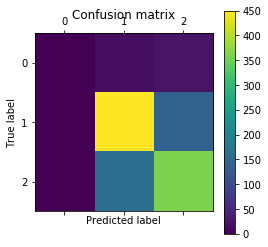

[[  0  17  23]
 [  0 450 139]
 [  0 164 362]]


In [53]:
X = round3_dm.toarray()  
y = newsdf['Audience'].values #this is an array of labels - don't need to define this again but in case you forgot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) #random_state is set seed
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

create_cm(clf3_expected, clf3_predicted)


### Is this okay?  We've got nearly 70% overall accuracy but we never predict one class correctly?  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.5670995670995671
accuracy: 0.5670995670995671
             precision    recall  f1-score   support

   Everyone       0.08      0.10      0.09        40
  Executive       0.61      0.59      0.60       589
      Staff       0.57      0.58      0.57       526

avg / total       0.57      0.57      0.57      1155



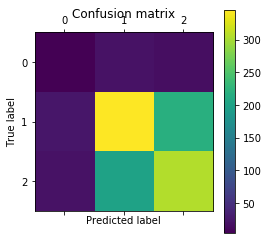

[[  4  20  16]
 [ 25 345 219]
 [ 20 200 306]]


In [54]:
# Decision trees seemed to be the only ones who handled the 
# class imbalance well although the overall accuracy was lower.  Let's try
# that with our new feature space
# Decision Tree Classifier

X = round3_dm.toarray()  
y = newsdf['Audience'].values #this is an array of labels - don't need to define this again but in case you forgot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) #random_state is set seed
model = DecisionTreeClassifier(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))
final_model_names = round3.get_feature_names()

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

create_cm(clf3_expected, clf3_predicted)


### How do we use this model to predict?  Bring in new news



In [56]:
wsjnewsdf = pd.read_csv(pathname + "\\wsjnews.csv") 

print(wsjnewsdf.shape)
print(list(wsjnewsdf))
wsjnewsdf.head()

(201, 5)
['Unnamed: 0', 'Unnamed: 0.1', 'date', 'text', 'likes']


,Unnamed: 0,Unnamed: 0.1,date,text,likes
0,0,0,12/31/14,"Gold prices ended down for second year in a row, weighed down by investors' expectations of higher U.S. interest rates and tame inflation around the world.</br></br>Gold for February delivery, the most actively traded contract, closed down $16.30, at $1,184.10 a troy ounce on the Comex division of the New York Mercantile Exchange. Prices fell 1.5% for the year.</br></br>A stronger dollar weighed on gold Wednesday, making the metal more expensive for buyers holding other currencies. The WSJ Dollar Index, which gauges the dollar against other major currencies, was recently up 0.4%, at 83.00.</br></br>""The way things stand, I would be looking to sell into any rallies from here,"" said Bob Haberkorn, a broker at RJO Futures. ""Gold will continue to be weak because of rate expectations.""</br></br>An improving U.S. economy has sparked expectations that the Federal Reserve will raise interest rates in 2015, a move that would hurt gold, which struggles to compete with yield-bearing investments in times of tighter monetary policy. At the same time, inflation has been elusive in the world's major economies, reducing gold's attractiveness as a hedge against rising consumer prices.",202.0
1,1,1,12/26/14,"Gold prices rose Friday, as investors locked in profits on bets for the precious metal's decline in a thinly traded market.</br></br>Gold for February delivery, the most actively traded contract, closed up $21.80, or 1.9%, at $1,195.30 a troy ounce on the Comex division of the New York Mercantile Exchange. It was the highest settlement since Dec. 19.</br></br>Prices for the precious metal are down 3% from December's highs, as a swiftly improving U.S. economy has raised concerns that the Federal Reserve will lift interest rates sooner than expected in 2015. Gold struggles to compete with yield-bearing investments when rates rise.</br></br>On Friday, some investors appeared to be buying gold to cover their bets on a decline in prices, while others were looking for bargains after the metal's drop, analysts said.</br></br>""Thin, postholiday trading conditions are likely exacerbating the bigger daily price move,"" said Jim Wyckoff, an analyst at Kitco.com, in a note to clients. ""Many traders and investors have checked out for the week, if not for the rest of the year.""",894.0
2,2,2,12/24/14,"The dollar gained against the yen and the euro on Tuesday after the U.S. economy grew at the fastest pace in 11 years, bolstering the market's expectations for higher interest rates.</br></br>The dollar increased 0.6% in late-afternoon trade to 120.77 yen, a two-week high. The euro pushed to a more than two-year low in early trade and was recently down 0.5% to $1.2169.</br></br>U.S. gross domestic product grew 5% in the third quarter, well above last month's estimate of 3.9%, the Commerce Department said Tuesday. It was the fastest pace since GDP grew 6.9% during the third quarter of 2003.</br></br>The GDP data encouraged investors who have been betting that a recovering U.S. economy would spur the Federal Reserve to raise interest rates before other major central banks do. Higher U.S. rates would bring more investors to the dollar, as they would increase returns on assets denominated in the currency.</br></br>""With 5% growth in the U.S. now, even if we don't improve at that pace next quarter, we're still light years ahead of the eurozone and Japan,"" said Joseph Quinlan, chief market strategist at U.S. Trust Private Wealth Management.",2202.0
3,3,3,12/23/14,"The dollar gained against the yen and the euro on Tuesday after the U.S. economy grew at , bolstering the market's expectations for higher interest rates.</br></br>The dollar increased 0.6% in late-afternoon trade to 120.77 yen, a two-week high. The euro pushed to a more than two-year low in early trade and was recently down 0.5% to $1.2169.</br></br>U.S. gross domestic product grew 5% in the third quarter, well above last month's estimate

### What prep do we need to do? What if we just vectorize the space as is? 


In [57]:
## what prep do we need to do? What if we just vectorize the space as is? 

wsjcv_dm = cv1.fit_transform(wsjnewsdf['text'])#

print(wsjcv_dm.shape)

# that's not the same feature space that we had before so it won't work
wsjcv_predicted = model.predict(wsjcv_dm)


(201, 446)


ValueError: Number of features of the model must match the input. Model n_features is 497 and input n_features is 446 

### We need to create the counts for this space using the vocab from our first space
### Remember, we captured our feature names with the list names

In [58]:

print(type(final_model_names))
print(len(final_model_names))


cvnews = CountVectorizer(lowercase=True, 
                     stop_words=my_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2),
                     vocabulary = final_model_names) 


wsjcv_dm = cvnews.fit_transform(wsjnewsdf['text'])

print(wsjcv_dm.shape)

# that's not the same feature space that we had before so it won't work
#wsjcv_predicted = model.predict(wsjcv_dm)

<class 'list'>
497
(201, 497)


In [59]:
# now do our prediction

wsjcv_predicted = model.predict(wsjcv_dm)
print(wsjcv_predicted.shape)
print(wsjcv_predicted[0:10])

(201,)
['Executive' 'Staff' 'Everyone' 'Everyone' 'Staff' 'Staff' 'Staff' 'Staff'
 'Staff' 'Executive']


### Now we have our predicted labels.  Are they "right"?  In general we'll never know.  We know we used a model with around 70% accuracy so we would assume that prediction rate here.  


### Things to consider:
* We've forced this text to take on our specific feature space.  Therefore, we are getting the information about this text that conforms to our model.  If there are "important" tokens in the WSJ that are not part of our feature space, we are not capturing that. As we assumed in class, they are being ignored. 
* We haven't done the full preprocessing on the new text so we may not be getting a comparable count for some of our features:  "states" will still appear and will be ignored because it's not in our vocabulary and the count for "state" won't be comparable because we aren't adding in the reformed "state" items. 
* Depending on your compute power, timing for producing results, and level of complexity for the preprocessing, you may or may not take all the preparatory steps on the new data before running it through your model.  You will lose accuracy because you are not quite matching your current data to what the model expects but that might be okay.  

## What if we are losing important information when we drop the feature space from 1200 to 500?  Can we get fewer features and capture the same variation?

## Principal Component Analysis (PCA)!!!

Principal Component Analysis (PCA) is a dimensionality-reduction technique that is often used to transform a high-dimensional dataset into a smaller-dimensional subspace prior to running a machine learning algorithm on the data.

PCA is helpful because:
* Most algorithms will run significantly faster if they have fewer dimensions they need to look at.
* Reducing the dimensionality of the dataset reduces the number of degrees of freedom of the hypothesis, which reduces the risk of overfitting.
* Reducing the dimensionality via PCA can simplify the dataset, facilitating description, visualization, and insight.

Link: http://scikit-learn.org/stable/modules/decomposition.html#decompositions 
Full version of the summary below:  http://www.lauradhamilton.com/introduction-to-principal-component-analysis-pca

In [60]:
from IPython.display import display, Image
display(Image(url='http://www.lauradhamilton.com/posts/2014/pca-original-dataset.png'))
print("Let’s say our original dataset has two variables, x1 and x2.")
display(Image(url='http://www.lauradhamilton.com/posts/2014/pca-first-principal-component.png'))
print("If we draw a line that splits the oval lengthwise, that line signifies the component that explains the most variance.")
display(Image(url='http://www.lauradhamilton.com/posts/2014/pca-first-component-projection.png'))
print("We would collapse our dataset onto a single line (by projecting it onto that line).")
display(Image(url='http://www.lauradhamilton.com/posts/2014/pca-projected-to-one-dimension.png'))
print("The projected representation of the data onto a single dimension corresponds to the first principal component.")

Let’s say our original dataset has two variables, x1 and x2.


If we draw a line that splits the oval lengthwise, that line signifies the component that explains the most variance.


We would collapse our dataset onto a single line (by projecting it onto that line).


The projected representation of the data onto a single dimension corresponds to the first principal component.


In [62]:
# Is this what we need to get better predictions for our news articles?
# First question:  How many components?

# Our original feature space was pretty big
print(cv_dm.shape)

# the next round was smaller
print(round3_dm.shape)

from sklearn.decomposition import PCA, RandomizedPCA

# we want something that is smaller than 1200 
# let's start with 500 - that's about how big the second round space was
# maybe we've kept more info for the same number of features


pca = PCA(n_components=500)
X_pca = pca.fit_transform(cv_dm.toarray())

print( 'PCA Total Variance Explained: ' + str(sum(pca.explained_variance_ratio_)))


(3848, 1236)
(3848, 497)
PCA Total Variance Explained: 0.8807207899032254


In [63]:
#set up our test and training vectors with the PCA'd vector space
X = X_pca  #remember this is the output from the vectorizer and we are turning it into an array
y = newsdf['Audience'].values #this is an array of labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed


# fit a decision treel to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))




0.567965367965368
accuracy: 0.567965367965368
             precision    recall  f1-score   support

   Everyone       0.05      0.05      0.05        58
  Executive       0.62      0.62      0.62       599
      Staff       0.56      0.56      0.56       498

avg / total       0.57      0.57      0.57      1155



### Can't use Naive Bayes here - why?

In [64]:
# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.7090909090909091
accuracy: 0.7090909090909091
             precision    recall  f1-score   support

   Everyone       0.14      0.09      0.11        58
  Executive       0.75      0.76      0.75       599
      Staff       0.70      0.72      0.71       498

avg / total       0.70      0.71      0.70      1155



In [65]:
# Are these results any better?

# What about using the weighted feature space?
pca = PCA(n_components=500)
X_pca_tf = pca.fit_transform(tfidf_dm.toarray())
print( 'PCA Total Variance Explained: ' + str(sum(pca.explained_variance_ratio_)))


PCA Total Variance Explained: 0.7779048967175822


In [66]:
# Hmmmm.... same number of features, less variation explained....
# predictive power?


#set up our test and training vectors with the PCA'd vector space
X = X_pca_tf  
y = newsdf['Audience'].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# fit a decision tree model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)

print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.5541125541125541
accuracy: 0.5541125541125541
             precision    recall  f1-score   support

   Everyone       0.04      0.03      0.04        58
  Executive       0.62      0.59      0.61       599
      Staff       0.54      0.57      0.55       498

avg / total       0.55      0.55      0.55      1155



###  Did that help? 

In [67]:
# How do we know 500 is the "right" number?  How much of the variation do we need?
# What are the options? 

for i in range(0,len(names)-1, 50):

    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(cv_dm.toarray())
    print("Number of components: " + str(i))
    print('PCA Total Variance Explained: ' + str(sum(pca.explained_variance_ratio_)))


Number of components: 0
PCA Total Variance Explained: 0
Number of components: 50
PCA Total Variance Explained: 0.46851645869977515
Number of components: 100
PCA Total Variance Explained: 0.5765216954599504
Number of components: 150
PCA Total Variance Explained: 0.6452748332721319
Number of components: 200
PCA Total Variance Explained: 0.6997795944894853
Number of components: 250
PCA Total Variance Explained: 0.7440061367636682
Number of components: 300
PCA Total Variance Explained: 0.780706415552449
Number of components: 350
PCA Total Variance Explained: 0.8116555899416054
Number of components: 400
PCA Total Variance Explained: 0.8380736535023328
Number of components: 450
PCA Total Variance Explained: 0.8608569981266041
Number of components: 500
PCA Total Variance Explained: 0.8807671555369921
Number of components: 550
PCA Total Variance Explained: 0.8979186504374127
Number of components: 600
PCA Total Variance Explained: 0.9130199369347559
Number of components: 650
PCA Total Variance 

In [68]:
# let's try 600 components instead
pca = PCA(n_components=600)
X_pca = pca.fit_transform(cv_dm.toarray())

X = X_pca  
y = newsdf['Audience'].values 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed


# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)
clf = model.fit(X_train, y_train)
# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))



0.548051948051948
accuracy: 0.548051948051948
             precision    recall  f1-score   support

   Everyone       0.02      0.02      0.02        58
  Executive       0.61      0.62      0.62       599
      Staff       0.53      0.52      0.52       498

avg / total       0.54      0.55      0.55      1155



## What about adding external information to help with prediction?  

### We have data on "likes" - how do we use that?

In [76]:
# Add this column to our feature space - cv_dm
# Let's use the "Big" feature space instead of the 500 feature version

print(cv_dm.shape)

Xdf = pd.DataFrame(cv_dm.toarray())
Xdf['likes'] = np.transpose(newsdf.likes.values)

print(Xdf.shape)

(3848, 1236)
(3848, 1237)


In [77]:
X = Xdf
Y = newsdf.Audience
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2693, 1237)
(1155, 1237)
(2693,)
(1155,)


In [78]:
# Logistic Regression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8242424242424242
accuracy: 0.8242424242424242
             precision    recall  f1-score   support

   Everyone       0.55      0.21      0.30        58
  Executive       0.82      0.85      0.83       599
      Staff       0.84      0.87      0.85       498

avg / total       0.82      0.82      0.82      1155



### Wow, in this case the number of "likes" increased our predictive power tremendously!

We should definitely use these data for our prediction.  Let's do that and see how much our predictions change.  

In [72]:
# Need to re-create wsj feature space using the larger feature list captured in big_feature_list

print(len(big_feature_list))

cvnews2 = CountVectorizer(lowercase=True, 
                     stop_words=my_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2),
                     vocabulary = big_feature_list) 


wsjcv_dm2 = cvnews2.fit_transform(wsjnewsdf['text'])
print(wsjcv_dm2.shape)

Wdf = pd.DataFrame(wsjcv_dm2.toarray())
Wdf['likes'] = np.transpose(wsjnewsdf.likes.values)

print(Wdf.shape)

1236
(201, 1236)
(201, 1237)


In [73]:
# now do our prediction

wsjcv2_predicted = model.predict(Wdf)
print(wsjcv_predicted.shape)
print(wsjcv_predicted[0:10])

(201,)
['Executive' 'Staff' 'Everyone' 'Everyone' 'Staff' 'Staff' 'Staff' 'Staff'
 'Staff' 'Executive']


### Does this make a difference?  Does it change many of the label assignments?

In [74]:
diff = np.where(wsjcv_predicted != wsjcv2_predicted)
print(len(diff[0]))

131


### Is this "right"?  

We don't know.  We don't know the truth.  We only know that we used all the information we had to make a prediction using a model that had about 80% accuracy.  That is better than the model we had before. 

#### Note:  when you include external information, you need to worry about comparability of measures.
When we are only using counts or tfidf weights from our feature space, all the units are comparable.  When we added in likes, they are measured on a different scale.  Remember, some models are VERY sensative to scale discrepancies.  We may need to scale information that we include so that it is more comparable to our feature space representation.


In [75]:
# Do we need to worry about the addition of likes to our count vectorized feature space?
# range of values for "likes"
print(max(Wdf['likes']))
print((min(Wdf['likes'])))

# range of values for bag of words
print(max(keep_count['count']))
print(min(keep_count['count']))

#I think we are good here

7026.0
7.0
21374
1


### Main take aways:
* Predictive models can be applied to text. Tonight we looked at supervised learning methods. 
* Lots of feature space options came into play tonight - we looked at how to use PCA as another tool. 
* Sentiment analysis models are trained on a specific corpus and then prediction is done to assign sentiment labels to new text. 
* Which classifier to use with which settings are more choices that the data scientist needs to make (on top of label creation options (dictionary/index), preprocesing options (stop word lists, stemming/lemmatization), vectorizer options, parameter settings, etc.))

